In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
import plotly.offline as pyoff
import plotly.graph_objs as go

Churn prediction
- exploratory data analysis
- feature engineering
- logistic regression
- XGBoost

# Data

In [ ]:
# telco_df
telco_df = pd.read_csv('data/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print('telco_df has {} rows and {} columns'.format(telco_df.shape[0], telco_df.shape[1]))

telco_df has 7043 rows and 21 columns


## Data summary
- info
- numerical and categorical features
- missing values check
- balance check

In [ ]:
# info
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# columns
columns = telco_df.columns
columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# numerical features
# telco_df.select_dtypes(np.number)

## 'TotalCharges': convert to numeric
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce', downcast='float')

num_features = telco_df.select_dtypes(np.number).columns

print(num_features)
print('number of numerical features: {}'.format(len(num_features)))

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')
number of numerical features: 4


In [ ]:
# categorical features
# telco_df.drop(['customerID', 'Churn'], axis=1).select_dtypes(np.object)
cat_features = telco_df.drop(['customerID', 'Churn'], axis=1).select_dtypes(np.object).columns

print(cat_features)
print('number of categorical features: {}'.format(len(cat_features)))

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
number of categorical features: 15


In [ ]:
# missing values check
telco_df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
# remove missing values: 11
telco_df = telco_df.dropna()

In [ ]:
# 'Churn' balance check
## 'Churn': convert 'Yes'=1, 'No'=0
telco_df.loc[telco_df['Churn']=='Yes', 'Churn'] = 1
telco_df.loc[telco_df['Churn']=='No', 'Churn'] = 0

telco_df['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [ ]:
## 'Churn': convert to numeric
telco_df['Churn'] = pd.to_numeric(telco_df['Churn'], downcast='integer')

print('% of 0 values: {}'.format(telco_df['Churn'].value_counts()[0]/telco_df['Churn'].value_counts().sum()))
print('% of 1 values: {}'.format(telco_df['Churn'].value_counts()[1]/telco_df['Churn'].value_counts().sum()))

% of 0 values: 0.7342150170648464
% of 1 values: 0.26578498293515357


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



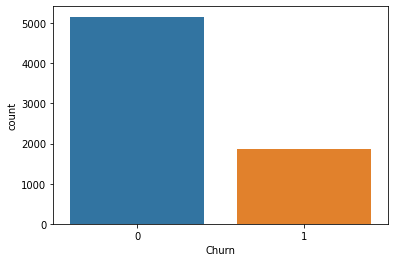

In [ ]:
## plot
# telco_df['Churn'].value_counts().plot(kind='bar')
# plt.show()

sns.countplot(telco_df['Churn'])
plt.show()

# Exploratory data analysis
- churn rate
- categorical features: bar
- numerical features: scatter

In [ ]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.850000,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.500000,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.750000,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994,1


In [ ]:
# churn rate: mean of 'Churn'
telco_df['Churn'].mean()

0.26578498293515357

## Categorical features

In [ ]:
# 1. gender
telco_df['gender'].value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64

In [ ]:
## churn rate by gender
plot_df = telco_df.groupby('gender')['Churn'].mean().reset_index()
plot_df

,gender,Churn
0,Female,0.269595
1,Male,0.262046


In [ ]:
## plot
# import plotly.offline as pyoff
# import plotly.graph_objs as go
plot_data = [
    go.Bar(
        x=plot_df['gender'],
        y=plot_df['Churn'],
        width=[0.5, 0.5],
        marker=dict(color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category'},
        yaxis={'title': 'Churn rate'},
        title='Gender',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# 6. InternetService
telco_df['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [ ]:
## churn rate by InternetService
plot_df = telco_df.groupby('InternetService')['Churn'].mean().reset_index()
plot_df

,InternetService,Churn
0,DSL,0.189983
1,Fiber optic,0.418928
2,No,0.074342


In [ ]:
## plot
plot_data = [
    go.Bar(
        x=plot_df['InternetService'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category'},
        yaxis={'title': 'Churn rate'},
        title='InternetService',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# 10. TechSupport
telco_df['TechSupport'].value_counts()

No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64

In [ ]:
## churn rate by TechSupport
plot_df = telco_df.groupby('TechSupport')['Churn'].mean().reset_index()
plot_df

,TechSupport,Churn
0,No,0.416475
1,No internet service,0.074342
2,Yes,0.151961


In [ ]:
## plot
plot_data = [
    go.Bar(
        x=plot_df['TechSupport'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category'},
        yaxis={'title': 'Churn rate'},
        title='TechSupport',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# 13. Contract
telco_df['Contract'].value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

In [ ]:
## churn rate by Contract
plot_df = telco_df.groupby('Contract')['Churn'].mean().reset_index()
plot_df

,Contract,Churn
0,Month-to-month,0.427097
1,One year,0.112772
2,Two year,0.028487


In [ ]:
## plot
plot_data = [
    go.Bar(
        x=plot_df['Contract'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category'},
        yaxis={'title': 'Churn rate'},
        title='Contract',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# 15. PaymentMethod
telco_df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

In [ ]:
## churn rate by PaymentMethod
plot_df = telco_df.groupby('PaymentMethod')['Churn'].mean().reset_index()
plot_df

,PaymentMethod,Churn
0,Bank transfer (automatic),0.167315
1,Credit card (automatic),0.152531
2,Electronic check,0.452854
3,Mailed check,0.192020


In [ ]:
## plot
plot_data = [
    go.Bar(
        x=plot_df['PaymentMethod'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange', 'red'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category'},
        yaxis={'title': 'Churn rate'},
        title='PaymentMethod',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Numerical features
- tenure
- MonthlyCharges
- TotalCharges

In [ ]:
# 1. tenure
telco_df['tenure'].describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

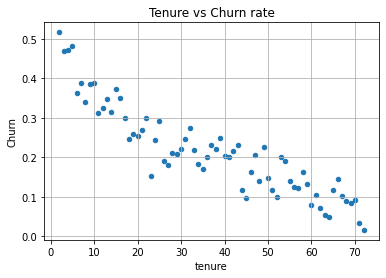

In [ ]:
## churn rate by tenure: higher tenure lower churn rate
plot_df = telco_df.groupby('tenure')['Churn'].mean().reset_index()

## plot
plot_df[1:].plot(x='tenure', y='Churn', kind='scatter', grid=True, title='Tenure vs Churn rate')
plt.show()

In [ ]:
## plot
plot_data = [
    go.Scatter(
        x=plot_df['tenure'][1:],
        y=plot_df['Churn'][1:],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    )
]

plot_layout = go.Layout(
        xaxis={'title': 'Tenure'},
        yaxis={'title': 'Churn rate'},
        title='Tenure vs Churn rate',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# 2. MonthlyCharges
telco_df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

In [ ]:
## churn rate by MonthlyCharges: no trend
plot_df = telco_df.groupby('MonthlyCharges')['Churn'].mean().reset_index()

## plot
plot_data = [
    go.Scatter(
        x=plot_df['MonthlyCharges'],
        y=plot_df['Churn'],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    )
]

plot_layout = go.Layout(
        xaxis={'title': 'MonthlyCharges'},
        yaxis={'title': 'Churn rate'},
        title='Monthly charge vs Churn rate',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# 2. TotalCharges
telco_df['TotalCharges'].describe()

count    7032.000000
mean     2283.298340
std      2266.770508
min        18.799999
25%       401.449997
50%      1397.475037
75%      3794.737488
max      8684.799805
Name: TotalCharges, dtype: float64

In [ ]:
## churn rate by TotalCharges: no trend
plot_df = telco_df.groupby('TotalCharges')['Churn'].mean().reset_index()

## plot
plot_data = [
    go.Scatter(
        x=plot_df['TotalCharges'],
        y=plot_df['Churn'],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    )
]

plot_layout = go.Layout(
        xaxis={'title': 'TotalCharges'},
        yaxis={'title': 'Churn rate'},
        title='Total charge vs Churn rate',
        plot_bgcolor='rgb(243, 243, 243)',
        paper_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Feature engineering
- numerical features: clustering
- categorical features: label + onehot encoding


## Numerical features
- tenure, MonthlyCharges, TotalCharges
- Kmeans clustering using Elbow method
- profile of clusters
- plot bar

### - tenure

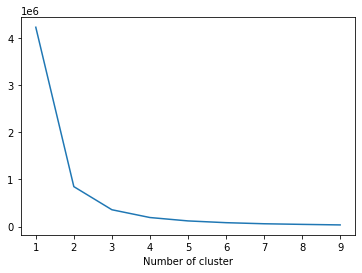

In [ ]:
# identify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster_df = telco_df[['tenure']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster_df)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=3
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(telco_df[['tenure']])

telco_df['tenureCluster'] = kmeans.predict(telco_df[['tenure']])
telco_df[['customerID', 'tenure', 'tenureCluster']].head()

,customerID,tenure,tenureCluster
0,7590-VHVEG,1,1
1,5575-GNVDE,34,0
2,3668-QPYBK,2,1
3,7795-CFOCW,45,0
4,9237-HQITU,2,1


In [ ]:
# cluster profile: not in order
telco_df.groupby('tenureCluster')['tenure'].describe()

,count,mean,std,min,25%,50%,75%,max
tenureCluster,,,,,,,,
0,1929.0,34.792120,8.297679,22.0,27.0,35.0,42.0,49.0
1,2930.0,7.830717,6.220431,1.0,2.0,6.0,13.0,21.0
2,2173.0,63.475380,7.172433,50.0,57.0,65.0,70.0,72.0


In [ ]:
# function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})

    return df_final

In [ ]:
# get clusters ordered
telco_df = order_cluster('tenureCluster', 'tenure', telco_df, ascending=True)
telco_df[['customerID', 'tenure', 'tenureCluster']].head()

,customerID,tenure,tenureCluster
0,7590-VHVEG,1,0
1,3668-QPYBK,2,0
2,9237-HQITU,2,0
3,9305-CDSKC,8,0
4,6713-OKOMC,10,0


In [ ]:
telco_df['tenureCluster'] = telco_df['tenureCluster'].replace({0: 'Low', 1: 'Mid', 2: 'High'})

In [ ]:
# cluster profile
telco_df.groupby('tenureCluster')['tenure'].describe()

,count,mean,std,min,25%,50%,75%,max
tenureCluster,,,,,,,,
High,2173.0,63.475380,7.172433,50.0,57.0,65.0,70.0,72.0
Low,2930.0,7.830717,6.220431,1.0,2.0,6.0,13.0,21.0
Mid,1929.0,34.792120,8.297679,22.0,27.0,35.0,42.0,49.0


In [ ]:
# plot
plot_df = telco_df.groupby('tenureCluster')['Churn'].mean().reset_index()

plot_data = [
    go.Bar(
        x=plot_df['tenureCluster'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category', 'categoryarray': ['Low', 'Mid', 'High']},
        title='Tenure cluster vs Churn rate',
        plot_bgcolor = 'rgb(243, 243, 243)',
        paper_bgcolor = 'rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### - MonthlyCharges

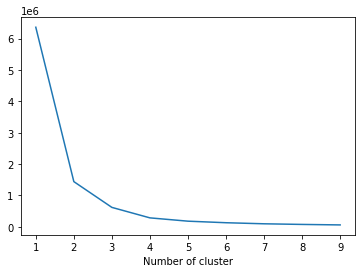

In [ ]:
# identify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster_df = telco_df[['MonthlyCharges']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster_df)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=3
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(telco_df[['MonthlyCharges']])

telco_df['MonthlyChargesCluster'] = kmeans.predict(telco_df[['MonthlyCharges']])
telco_df[['customerID', 'MonthlyCharges', 'MonthlyChargesCluster']].head()

,customerID,MonthlyCharges,MonthlyChargesCluster
0,7590-VHVEG,29.85,1
1,3668-QPYBK,53.85,2
2,9237-HQITU,70.70,2
3,9305-CDSKC,99.65,0
4,6713-OKOMC,29.75,1


In [ ]:
# cluster profile: not in order
telco_df.groupby('MonthlyChargesCluster')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargesCluster,,,,,,,,
0,2909.0,94.069938,10.337638,77.90,85.1,93.90,101.95,118.75
1,1886.0,23.389608,5.666778,18.25,19.8,20.40,25.05,42.40
2,2237.0,61.644502,10.451979,42.60,51.8,61.55,70.70,77.85


In [ ]:
# get clusters ordered
telco_df = order_cluster('MonthlyChargesCluster', 'MonthlyCharges', telco_df, ascending=True)
telco_df[['customerID', 'MonthlyCharges', 'MonthlyChargesCluster']].head()

,customerID,MonthlyCharges,MonthlyChargesCluster
0,7590-VHVEG,29.85,0
1,6713-OKOMC,29.75,0
2,7469-LKBCI,18.95,0
3,8779-QRDMV,39.65,0
4,1680-VDCWW,19.80,0


In [ ]:
telco_df['MonthlyChargesCluster'] = telco_df['MonthlyChargesCluster'].replace({0: 'Low', 1: 'Mid', 2: 'High'})

In [ ]:
# cluster profile
telco_df.groupby('MonthlyChargesCluster')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargesCluster,,,,,,,,
High,2909.0,94.069938,10.337638,77.90,85.1,93.90,101.95,118.75
Low,1886.0,23.389608,5.666778,18.25,19.8,20.40,25.05,42.40
Mid,2237.0,61.644502,10.451979,42.60,51.8,61.55,70.70,77.85


In [ ]:
# plot
plot_df = telco_df.groupby('MonthlyChargesCluster')['Churn'].mean().reset_index()

plot_data = [
    go.Bar(
        x=plot_df['MonthlyChargesCluster'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category', 'categoryarray': ['Low', 'Mid', 'High']},
        title='MonthlyCharges cluster vs Churn rate',
        plot_bgcolor = 'rgb(243, 243, 243)',
        paper_bgcolor = 'rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### - TotalCharges

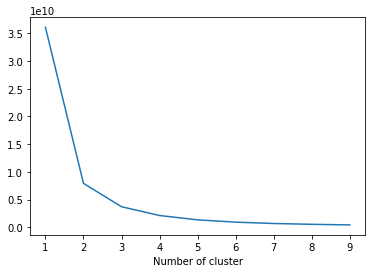

In [ ]:
# identify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster_df = telco_df[['TotalCharges']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster_df)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=3
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(telco_df[['TotalCharges']])

telco_df['TotalChargesCluster'] = kmeans.predict(telco_df[['TotalCharges']])
telco_df[['customerID', 'TotalCharges', 'TotalChargesCluster']].head()

,customerID,TotalCharges,TotalChargesCluster
0,7590-VHVEG,29.850000,0
1,6713-OKOMC,301.899994,0
2,7469-LKBCI,326.799988,0
3,8779-QRDMV,39.650002,0
4,1680-VDCWW,202.250000,0


In [ ]:
# cluster profile: not in order
telco_df.groupby('TotalChargesCluster')['TotalCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargesCluster,,,,,,,,
0,4145.0,681.571167,567.841858,18.799999,160.850006,533.049988,1131.500000,1955.400024
1,1273.0,6276.092285,1010.606995,4747.850098,5443.649902,6137.000000,7031.450195,8684.799805
2,1614.0,3247.579102,811.487732,1956.400024,2530.649902,3187.174927,3952.599915,4747.649902


In [ ]:
# get clusters ordered
telco_df = order_cluster('TotalChargesCluster', 'TotalCharges', telco_df, ascending=True)
telco_df[['customerID', 'TotalCharges', 'TotalChargesCluster']].head()

,customerID,TotalCharges,TotalChargesCluster
0,7590-VHVEG,29.850000,0
1,6713-OKOMC,301.899994,0
2,7469-LKBCI,326.799988,0
3,8779-QRDMV,39.650002,0
4,1680-VDCWW,202.250000,0


In [ ]:
telco_df['TotalChargesCluster'] = telco_df['TotalChargesCluster'].replace({0: 'Low', 1: 'Mid', 2: 'High'})

In [ ]:
# cluster profile:
telco_df.groupby('TotalChargesCluster')['TotalCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargesCluster,,,,,,,,
High,1273.0,6276.092285,1010.606995,4747.850098,5443.649902,6137.000000,7031.450195,8684.799805
Low,4145.0,681.571167,567.841858,18.799999,160.850006,533.049988,1131.500000,1955.400024
Mid,1614.0,3247.579102,811.487732,1956.400024,2530.649902,3187.174927,3952.599915,4747.649902


In [ ]:
# plot
plot_df = telco_df.groupby('TotalChargesCluster')['Churn'].mean().reset_index()

plot_data = [
    go.Bar(
        x=plot_df['TotalChargesCluster'],
        y=plot_df['Churn'],
        width=[0.5, 0.5, 0.5],
        marker=dict(color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={'type': 'category', 'categoryarray': ['Low', 'Mid', 'High']},
        title='TotalCharges cluster vs Churn rate',
        plot_bgcolor = 'rgb(243, 243, 243)',
        paper_bgcolor = 'rgb(243, 243, 243)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
telco_df[['customerID', 'tenure', 'tenureCluster', 'MonthlyCharges', 'MonthlyChargesCluster', 'TotalCharges', 'TotalChargesCluster']].head()

,customerID,tenure,tenureCluster,MonthlyCharges,MonthlyChargesCluster,TotalCharges,TotalChargesCluster
0,7590-VHVEG,1,Low,29.85,Low,29.850000,Low
1,6713-OKOMC,10,Low,29.75,Low,301.899994,Low
2,7469-LKBCI,16,Low,18.95,Low,326.799988,Low
3,8779-QRDMV,1,Low,39.65,Low,39.650002,Low
4,1680-VDCWW,12,Low,19.80,Low,202.250000,Low


## Categorical features
- apply label encoding to binary features
- apply onehot encoding to features that have multiple values

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

dummy_columns = [] # list of multiple value columns
for column in telco_df.columns:
    if telco_df[column].dtype == object and column != 'customerID':
        if telco_df[column].nunique() == 2:
            # apply label encoding for binary columns
            telco_df[column] = le.fit_transform(telco_df[column])
        else:
            dummy_columns.append(column)

In [ ]:
# onehot encoding: pd.get_dummies
# dummy_columns
telco_df = pd.get_dummies(data=telco_df, columns=dummy_columns)

In [ ]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenureCluster_High,tenureCluster_Low,tenureCluster_Mid,MonthlyChargesCluster_High,MonthlyChargesCluster_Low,MonthlyChargesCluster_Mid,TotalChargesCluster_High,TotalChargesCluster_Low,TotalChargesCluster_Mid
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.850000,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
1,6713-OKOMC,0,0,0,0,10,0,0,29.75,301.899994,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
2,7469-LKBCI,1,0,0,0,16,1,0,18.95,326.799988,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
3,8779-QRDMV,1,1,0,0,1,0,1,39.65,39.650002,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
4,1680-VDCWW,1,0,1,0,12,1,0,19.80,202.250000,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0


In [ ]:
# create data_df
data_df = telco_df.copy()

In [ ]:
# rename columns: ' ', '(', ')', '-' => '_'
all_columns = []
for column in data_df.columns:
    # print(column)
    column = column.replace(' ', '_').replace('(', '_').replace(')', '_').replace('-', '_')
    all_columns.append(column)

data_df.columns = all_columns
data_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaymentMethod_Bank_transfer__automatic_,PaymentMethod_Credit_card__automatic_,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,tenureCluster_High,tenureCluster_Low,tenureCluster_Mid,MonthlyChargesCluster_High,MonthlyChargesCluster_Low,MonthlyChargesCluster_Mid,TotalChargesCluster_High,TotalChargesCluster_Low,TotalChargesCluster_Mid
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.850000,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
1,6713-OKOMC,0,0,0,0,10,0,0,29.75,301.899994,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
2,7469-LKBCI,1,0,0,0,16,1,0,18.95,326.799988,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
3,8779-QRDMV,1,1,0,0,1,0,1,39.65,39.650002,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
4,1680-VDCWW,1,0,1,0,12,1,0,19.80,202.250000,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0


# Logistic regression
- statsmodels generalized linear model (glm)
- preparation
- model summary

In [ ]:
# glm_columns
glm_columns = 'gender'

for column in data_df.columns:
    if column not in ['customerID', 'gender', 'Churn']:
        glm_columns = glm_columns + ' + ' + column

glm_columns

'gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + PaperlessBilling + MonthlyCharges + TotalCharges + MultipleLines_No + MultipleLines_No_phone_service + MultipleLines_Yes + InternetService_DSL + InternetService_Fiber_optic + InternetService_No + OnlineSecurity_No + OnlineSecurity_No_internet_service + OnlineSecurity_Yes + OnlineBackup_No + OnlineBackup_No_internet_service + OnlineBackup_Yes + DeviceProtection_No + DeviceProtection_No_internet_service + DeviceProtection_Yes + TechSupport_No + TechSupport_No_internet_service + TechSupport_Yes + StreamingTV_No + StreamingTV_No_internet_service + StreamingTV_Yes + StreamingMovies_No + StreamingMovies_No_internet_service + StreamingMovies_Yes + Contract_Month_to_month + Contract_One_year + Contract_Two_year + PaymentMethod_Bank_transfer__automatic_ + PaymentMethod_Credit_card__automatic_ + PaymentMethod_Electronic_check + PaymentMethod_Mailed_check + tenureCluster_High + tenureCluster_Low + tenureCluster_Mid + Monthly

In [ ]:
# build glm_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=data_df, family=sm.families.Binomial())
glm_res = glm_model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# summary
print(glm_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2902.2
Date:                Tue, 27 Oct 2020   Deviance:                       5804.4
Time:                        12:21:59   Pearson chi2:                 7.56e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
# p-value
glm_res.pvalues

Intercept                                  3.627058e-01
gender                                     7.253205e-01
SeniorCitizen                              8.941083e-03
Partner                                    9.915070e-01
Dependents                                 1.460372e-01
tenure                                     2.011605e-13
PhoneService                               5.744532e-01
PaperlessBilling                           3.594973e-06
MonthlyCharges                             2.885498e-01
TotalCharges                               3.183337e-01
MultipleLines_No                           3.703499e-01
MultipleLines_No_phone_service             8.748205e-01
MultipleLines_Yes                          2.263680e-01
InternetService_DSL                        7.548087e-03
InternetService_Fiber_optic                6.887565e-02
InternetService_No                         3.215270e-02
OnlineSecurity_No                          2.520006e-03
OnlineSecurity_No_internet_service         3.215

In [ ]:
# odds ratio for churning: exponential coefs
np.exp(glm_res.params)

Intercept                                  1.285993
gender                                     0.977411
SeniorCitizen                              1.248132
Partner                                    0.999169
Dependents                                 0.877268
tenure                                     0.940753
PhoneService                               1.253925
PaperlessBilling                           1.414188
MonthlyCharges                             0.966739
TotalCharges                               1.000099
MultipleLines_No                           0.890205
MultipleLines_No_phone_service             1.025574
MultipleLines_Yes                          1.408580
InternetService_DSL                        0.546727
InternetService_Fiber_optic                2.860019
InternetService_No                         0.822430
OnlineSecurity_No                          1.386156
OnlineSecurity_No_internet_service         0.822430
OnlineSecurity_Yes                         1.128047
OnlineBackup

Interpretation:
- one unit change (increase) in MonthlyCharges means ~3.3% (1 - 0.967) improvement (decrease) in the odds for churning (if everything else kept constant)
- (if everything else unchanged) odds for churning of SeniorCitizen is 25.1% higher than that of non SeniorCitizen, or SeniorCitizen is 25.1% more likely to churn

# Binary classification model: XGBoost
- XGBoost
- preparation
- train and test split
- evaluation

In [ ]:
# create feature set and label
X = data_df.drop(['customerID', 'Churn'], axis=1)
y = data_df['Churn']

In [ ]:
# train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
# build xgb_model
## binary classification => objective='binary:logistic'
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='binary:logistic', n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# accuracy
# from sklearn.metrics import accuracy_score

print('accuracy of XGBClassifier on training set: {}'.format(xgb_model.score(X_train, y_train)))
print('accuracy of XGBClassifier on test set: {}'.format(xgb_model.score(X_test, y_test)))

accuracy of XGBClassifier on training set: 0.8462574850299401
accuracy of XGBClassifier on test set: 0.8238636363636364


In [ ]:
# y_pred
y_pred = xgb_model.predict(X_test)

In [ ]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       260
           1       0.68      0.61      0.64        92

    accuracy                           0.82       352
   macro avg       0.77      0.75      0.76       352
weighted avg       0.82      0.82      0.82       352



Intepretation:
- precision = TP / (TP + FP) = 0.61: 61/100 customers predicted to churn by the model will actually churn
- recall = TP / (TP + FN) = 0.47: 47/100 customers churned in reality can be precisely predicted by the model

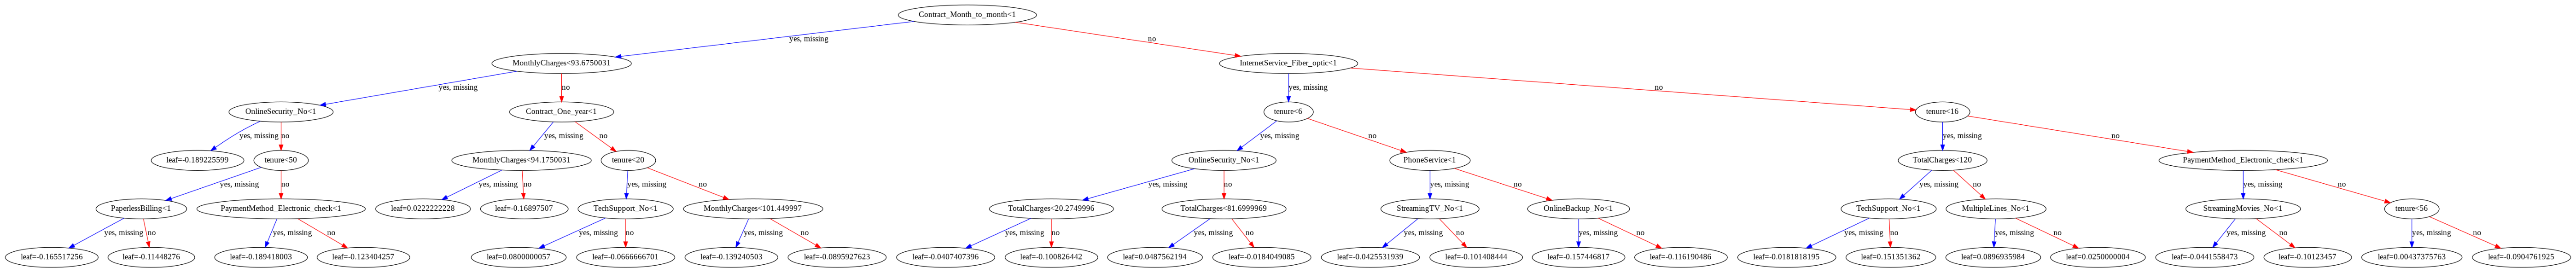

In [ ]:
# plot_tree
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(xgb_model, ax=ax)
plt.show()

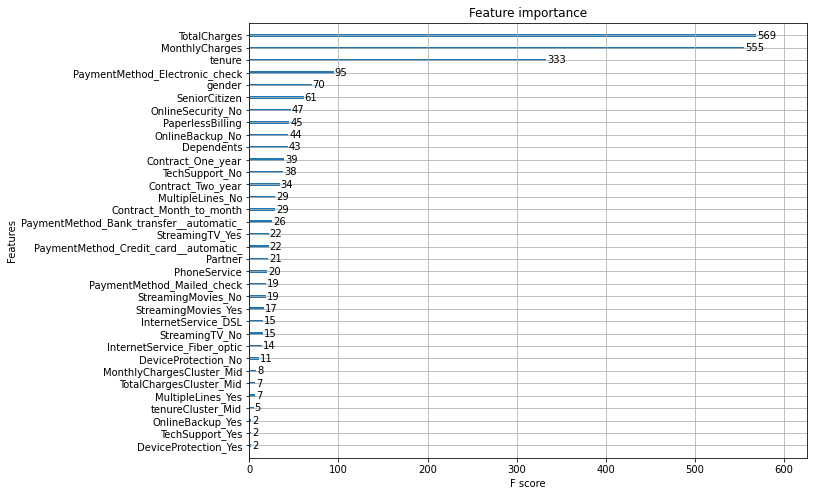

In [ ]:
# plot_importance
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_model, ax=ax)
plt.show()

Which features were used by the model?
- the model assigned more importance to gender, PaymentMethod (by electronic check) and PaperlessBilling

In [ ]:
# Churn probability
# xgb_model.predict_proba(X_train)
data_df['proba'] = xgb_model.predict_proba(X)[:, 1]
data_df['prediction'] = xgb_model.predict(X)
data_df[['customerID', 'Churn', 'proba', 'prediction']].tail()

,customerID,Churn,proba,prediction
7027,7203-OYKCT,0,0.151361,0
7028,1035-IPQPU,0,0.445312,0
7029,0639-TSIQW,1,0.318596,0
7030,2234-XADUH,0,0.033846,0
7031,3186-AJIEK,0,0.110539,0
